<h1 style="text-align:center;">Quantitative Trading</h1>

<br>

<br>

# Initial Deployment

---

In [1]:
# Import the libraries
import requests, time, datetime, pytz, talib, warnings
import yfinance as yf
from itertools import compress
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow import keras

In [4]:
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

##### Customize the Pandas

In [5]:
# Show max rows
pd.set_option('display.max_rows', 200)

In [6]:
# Show max columns
pd.set_option('display.max_columns', None)

In [7]:
# Show 4 decimal point in dataframe
pd.options.display.float_format = "{:,.3f}".format

##### Customize the Matplotlib

In [8]:
# Set the matplotlib style
plt.style.use("seaborn-darkgrid")

##### Turn-Off the Warnings

In [9]:
# Turn off all warnings
warnings.filterwarnings('ignore')

<br>

# Load the Dataset 

---

### TD Ameritrade API

In [10]:
# Function for fetching the minute level dataset
def fetch_minute_dataset(ticker_name = "TSLA"):
    
    # Client ID
    client_id = "E5AXP16J02E3JTODQW9LW7L1AH726L9X"

    # Get the current time
    current_time_epoch = str(int(time.time()) * 1000)

    # Endpoint
    endpoint = r"https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format(ticker_name)

    # Define the payload                
    payload = {"apikey": client_id,
               #"periodType": "day",
               #"period": "*1",
               "frequencyType": "minute",
               "frequency": "1",
               "endDate": current_time_epoch,        # Use "www.epochconverter.com" for getting the time
               "startDate": "1620826200000",
               "needExtendedHoursData": "false"}      # Only regular market hour

    # Make a request
    content = requests.get(url = endpoint, params = payload)

    # Convert data into a json dictionary
    data = content.json()

    # Get the dataset in dataframe form
    data = pd.DataFrame(data["candles"])
    
    return data

In [11]:
df = fetch_minute_dataset(ticker_name = "SPY")
print("Dataset Shape: ", df.shape)
df

Dataset Shape:  (4910, 6)


,open,high,low,close,volume,datetime
0,411.230,411.710,410.940,411.660,646169,1620826200000
1,411.670,412.100,411.520,411.580,555916,1620826260000
2,411.580,411.880,411.280,411.880,288527,1620826320000
3,411.870,412.050,411.640,411.760,293702,1620826380000
4,411.770,412.040,411.690,411.980,246648,1620826440000
...,...,...,...,...,...,...
4905,418.920,418.920,418.900,418.910,913,1622073300000
4906,418.910,418.910,418.910,418.910,256,1622073360000
4907,418.910,418.930,418.900,418.900,802,1622073420000
4908,418.900,418.920,418.900,418.900,436,1622073480000


In [12]:
def add_different_date_columns(df):
    """
    Function for adding date columns (i.e. "datetime", "year", "month", "day", "hour", "minute", "day name").
    """
    
    # Create a "date" only column
    def converter(x):
        x = datetime.datetime.fromtimestamp(x/1000, pytz.timezone("US/Eastern"))
        return "{}/{}/{}".format(x.year, x.month, x.day)

    df["date"] = df["datetime"].map(lambda x: converter(x))
    
    # Create the year, month, day, hour, and minute columns
    df["year"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).year)
    df["month"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).month)
    df["day"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).day)
    df["hour"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).hour)
    df["minute"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).minute)
    df["day name"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%A"))
    
    return df

In [13]:
df = add_different_date_columns(df)
print("Dataset Shape: ", df.shape)
print("Unique Hours: ", df["hour"].unique())
df

Dataset Shape:  (4910, 13)
Unique Hours:  [17 18 19 20 21 22 23  0  1  2  3]


,open,high,low,close,volume,datetime,date,year,month,day,hour,minute,day name
0,411.230,411.710,410.940,411.660,646169,1620826200000,2021/5/12,2021,5,12,17,30,Wednesday
1,411.670,412.100,411.520,411.580,555916,1620826260000,2021/5/12,2021,5,12,17,31,Wednesday
2,411.580,411.880,411.280,411.880,288527,1620826320000,2021/5/12,2021,5,12,17,32,Wednesday
3,411.870,412.050,411.640,411.760,293702,1620826380000,2021/5/12,2021,5,12,17,33,Wednesday
4,411.770,412.040,411.690,411.980,246648,1620826440000,2021/5/12,2021,5,12,17,34,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4905,418.920,418.920,418.900,418.910,913,1622073300000,2021/5/26,2021,5,27,3,55,Thursday
4906,418.910,418.910,418.910,418.910,256,1622073360000,2021/5/26,2021,5,27,3,56,Thursday
4907,418.910,418.930,418.900,418.900,802,1622073420000,2021/5/26,2021,5,27,3,57,Thursday
4908,418.900,418.920,418.900,418.900,436,1622073480000,2021/5/26,2021,5,27,3,58,Thursday


In [14]:
# Get hours from 17 to 23 only
df = df[(df["hour"]>=17) & (df["hour"]<=23)]
print("Unique Hours: ", df["hour"].unique())
df

Unique Hours:  [17 18 19 20 21 22 23]


,open,high,low,close,volume,datetime,date,year,month,day,hour,minute,day name
0,411.230,411.710,410.940,411.660,646169,1620826200000,2021/5/12,2021,5,12,17,30,Wednesday
1,411.670,412.100,411.520,411.580,555916,1620826260000,2021/5/12,2021,5,12,17,31,Wednesday
2,411.580,411.880,411.280,411.880,288527,1620826320000,2021/5/12,2021,5,12,17,32,Wednesday
3,411.870,412.050,411.640,411.760,293702,1620826380000,2021/5/12,2021,5,12,17,33,Wednesday
4,411.770,412.040,411.690,411.980,246648,1620826440000,2021/5/12,2021,5,12,17,34,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4675,418.720,418.745,418.660,418.710,468045,1622058900000,2021/5/26,2021,5,26,23,55,Wednesday
4676,418.710,418.845,418.650,418.760,349933,1622058960000,2021/5/26,2021,5,26,23,56,Wednesday
4677,418.765,418.790,418.610,418.690,536545,1622059020000,2021/5/26,2021,5,26,23,57,Wednesday
4678,418.690,418.780,418.610,418.770,347032,1622059080000,2021/5/26,2021,5,26,23,58,Wednesday


In [15]:
# Negate hours with 8 (time difference)
df["hour"] = df["hour"].map(lambda x: int(x-8))
print("Unique Hours: ", df["hour"].unique())
df

Unique Hours:  [ 9 10 11 12 13 14 15]


,open,high,low,close,volume,datetime,date,year,month,day,hour,minute,day name
0,411.230,411.710,410.940,411.660,646169,1620826200000,2021/5/12,2021,5,12,9,30,Wednesday
1,411.670,412.100,411.520,411.580,555916,1620826260000,2021/5/12,2021,5,12,9,31,Wednesday
2,411.580,411.880,411.280,411.880,288527,1620826320000,2021/5/12,2021,5,12,9,32,Wednesday
3,411.870,412.050,411.640,411.760,293702,1620826380000,2021/5/12,2021,5,12,9,33,Wednesday
4,411.770,412.040,411.690,411.980,246648,1620826440000,2021/5/12,2021,5,12,9,34,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4675,418.720,418.745,418.660,418.710,468045,1622058900000,2021/5/26,2021,5,26,15,55,Wednesday
4676,418.710,418.845,418.650,418.760,349933,1622058960000,2021/5/26,2021,5,26,15,56,Wednesday
4677,418.765,418.790,418.610,418.690,536545,1622059020000,2021/5/26,2021,5,26,15,57,Wednesday
4678,418.690,418.780,418.610,418.770,347032,1622059080000,2021/5/26,2021,5,26,15,58,Wednesday


### Yahoo Finance API

In [16]:
def load_dataset_yf(ticker_name, period='max', interval='1d',):
    
    # Set the ticker
    ticker = yf.Ticker(ticker_name)
    
    # Load the dataset
    df = ticker.history(period, interval).reset_index()
    
    # Rename the columns
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits']

    # Drop some columns
    df = df.drop(["dividends", "stock splits"], axis=1)
    
    return df

In [17]:
df = load_dataset_yf(ticker_name="SPY", period='max', interval='1d',)
df

,date,open,high,low,close,volume
0,1993-01-29,25.903,25.903,25.774,25.884,1003200
1,1993-02-01,25.903,26.068,25.903,26.068,480500
2,1993-02-02,26.050,26.142,25.995,26.123,201300
3,1993-02-03,26.160,26.418,26.142,26.400,529400
4,1993-02-04,26.492,26.565,26.197,26.510,531500
...,...,...,...,...,...,...
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700
7131,2021-05-25,420.330,420.710,417.620,418.240,57451400


<br>

# Feature Engineering

---

### Define Output (i.e. Profit Rate)

In [18]:
# Add price change
df["price diff"] = df['close'].pct_change()
df

,date,open,high,low,close,volume,price diff
0,1993-01-29,25.903,25.903,25.774,25.884,1003200,NaN
1,1993-02-01,25.903,26.068,25.903,26.068,480500,0.007
2,1993-02-02,26.050,26.142,25.995,26.123,201300,0.002
3,1993-02-03,26.160,26.418,26.142,26.400,529400,0.011
4,1993-02-04,26.492,26.565,26.197,26.510,531500,0.004
...,...,...,...,...,...,...,...
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010
7131,2021-05-25,420.330,420.710,417.620,418.240,57451400,-0.002


In [19]:
df["next close"] = df["close"].shift(-1)
df

,date,open,high,low,close,volume,price diff,next close
0,1993-01-29,25.903,25.903,25.774,25.884,1003200,NaN,26.068
1,1993-02-01,25.903,26.068,25.903,26.068,480500,0.007,26.123
2,1993-02-02,26.050,26.142,25.995,26.123,201300,0.002,26.400
3,1993-02-03,26.160,26.418,26.142,26.400,529400,0.011,26.510
4,1993-02-04,26.492,26.565,26.197,26.510,531500,0.004,26.492
...,...,...,...,...,...,...,...,...
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011,414.940
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001,419.170
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,418.240
7131,2021-05-25,420.330,420.710,417.620,418.240,57451400,-0.002,419.070


### Add Indicators

In [20]:
# Add relative volume (i.e. percentage of change in volume)
df["relative volume"] = df["volume"].pct_change()
df

,date,open,high,low,close,volume,price diff,next close,relative volume
0,1993-01-29,25.903,25.903,25.774,25.884,1003200,NaN,26.068,NaN
1,1993-02-01,25.903,26.068,25.903,26.068,480500,0.007,26.123,-0.521
2,1993-02-02,26.050,26.142,25.995,26.123,201300,0.002,26.400,-0.581
3,1993-02-03,26.160,26.418,26.142,26.400,529400,0.011,26.510,1.630
4,1993-02-04,26.492,26.565,26.197,26.510,531500,0.004,26.492,0.004
...,...,...,...,...,...,...,...,...,...
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011,414.940,-0.267
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001,419.170,-0.019
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,418.240,-0.329
7131,2021-05-25,420.330,420.710,417.620,418.240,57451400,-0.002,419.070,0.118


In [21]:
# Add RSI
time_periods = [14]
for i in time_periods:
    df.loc[:, f"RSI_{i}"] = talib.RSI(df["close"], timeperiod = i)

In [22]:
# Add EMA
time_periods = [9, 20, 50, 200]
for i in time_periods:
    df.loc[:, f"EMA_{i}"] = talib.EMA(df["close"], timeperiod = i)

In [23]:
# Add MACD
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(df["close"], fastperiod=12, slowperiod=26, signalperiod=9)

In [24]:
# TODO: Add more indicator

In [25]:
# Replace infinity with NaN
df = df.replace([np.inf, -np.inf], np.nan)

In [26]:
# Remove rows with NaN values
df.dropna(inplace=True)

In [27]:
df

,date,open,high,low,close,volume,price diff,next close,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist
199,1993-11-11,27.891,27.966,27.797,27.816,88900,-0.003,27.947,0.912,50.310,27.805,27.826,27.687,26.869,0.008,0.043,-0.034
200,1993-11-12,27.872,28.041,27.853,27.947,108200,0.005,27.928,0.217,54.494,27.834,27.837,27.697,26.880,0.018,0.038,-0.020
201,1993-11-15,28.003,28.003,27.853,27.928,243300,-0.001,28.060,1.249,53.797,27.853,27.846,27.706,26.890,0.024,0.035,-0.011
202,1993-11-16,27.985,28.078,27.872,28.060,492600,0.005,27.910,1.025,57.860,27.894,27.866,27.720,26.902,0.039,0.036,0.003
203,1993-11-17,28.078,28.078,27.835,27.910,39600,-0.005,27.835,-0.920,52.209,27.897,27.870,27.728,26.912,0.038,0.036,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7127,2021-05-19,406.920,411.050,405.330,410.860,106467100,-0.003,415.280,0.780,47.991,413.481,413.584,406.878,372.408,1.207,2.560,-1.353
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011,414.940,-0.267,53.255,413.841,413.746,407.208,372.835,1.232,2.295,-1.062
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001,419.170,-0.019,52.813,414.061,413.860,407.511,373.254,1.211,2.078,-0.867
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,418.240,-0.329,57.543,415.083,414.365,407.968,373.710,1.518,1.966,-0.448


### Add Trendlines + Support and Resistance Levels

In [28]:
# TODO: 

### Add Correlated Asset Classes

In [29]:
# Add future S&P 500
spy_futures = load_dataset_yf(ticker_name="ES=F")
df = df.merge(spy_futures[["date", "close"]].rename({"close":"s&p futures price"}, axis=1), on="date")
df

,date,open,high,low,close,volume,price diff,next close,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist,s&p futures price
0,2000-09-18,99.187,99.590,97.716,98.023,5109300,-0.009,98.912,0.251,35.528,100.239,100.771,100.362,97.239,-0.252,0.232,-0.483,"1,467.500"
1,2000-09-19,98.340,99.145,98.055,98.912,6588200,0.009,98.182,0.289,41.076,99.974,100.594,100.305,97.256,-0.361,0.113,-0.474,"1,478.500"
2,2000-09-20,98.722,98.955,97.006,98.182,6508100,-0.007,96.689,-0.012,38.170,99.616,100.365,100.222,97.265,-0.500,-0.010,-0.491,"1,469.500"
3,2000-09-21,97.896,98.637,96.646,96.689,5972300,-0.015,98.446,-0.082,33.029,99.030,100.014,100.083,97.259,-0.723,-0.152,-0.571,"1,469.500"
4,2000-09-22,96.646,98.467,96.509,98.446,7791300,0.018,97.748,0.305,42.798,98.913,99.865,100.019,97.271,-0.749,-0.272,-0.478,"1,468.500"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5164,2021-05-19,406.920,411.050,405.330,410.860,106467100,-0.003,415.280,0.780,47.991,413.481,413.584,406.878,372.408,1.207,2.560,-1.353,"4,111.500"
5165,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011,414.940,-0.267,53.255,413.841,413.746,407.208,372.835,1.232,2.295,-1.062,"4,154.250"
5166,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001,419.170,-0.019,52.813,414.061,413.860,407.511,373.254,1.211,2.078,-0.867,"4,151.750"
5167,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,418.240,-0.329,57.543,415.083,414.365,407.968,373.710,1.518,1.966,-0.448,"4,193.750"


In [30]:
# Add gold price
gold = load_dataset_yf(ticker_name="GLD")
df = df.merge(gold[["date", "close"]].rename({"close":"gold price"}, axis=1), on="date")
df

,date,open,high,low,close,volume,price diff,next close,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist,s&p futures price,gold price
0,2004-11-18,85.450,85.645,85.234,85.602,31854300,0.001,84.650,-0.415,72.189,84.787,83.563,82.000,79.712,1.303,1.077,0.226,"1,185.000",44.380
1,2004-11-19,85.573,85.587,84.448,84.650,54276500,-0.011,85.054,0.704,61.991,84.759,83.666,82.104,79.761,1.226,1.107,0.119,"1,172.250",44.780
2,2004-11-22,84.470,85.155,84.369,85.054,37560200,0.005,85.184,-0.308,64.296,84.818,83.798,82.220,79.814,1.184,1.122,0.062,"1,178.000",44.950
3,2004-11-23,85.018,85.256,84.614,85.184,41968800,0.002,85.386,0.117,65.029,84.891,83.930,82.336,79.867,1.148,1.128,0.021,"1,179.250",44.750
4,2004-11-24,85.263,85.494,85.104,85.386,29724800,0.002,85.321,-0.292,66.194,84.990,84.069,82.456,79.922,1.123,1.127,-0.004,"1,182.000",45.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4117,2021-05-19,406.920,411.050,405.330,410.860,106467100,-0.003,415.280,0.780,47.991,413.481,413.584,406.878,372.408,1.207,2.560,-1.353,"4,111.500",175.160
4118,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011,414.940,-0.267,53.255,413.841,413.746,407.208,372.835,1.232,2.295,-1.062,"4,154.250",175.960
4119,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001,419.170,-0.019,52.813,414.061,413.860,407.511,373.254,1.211,2.078,-0.867,"4,151.750",176.040
4120,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,418.240,-0.329,57.543,415.083,414.365,407.968,373.710,1.518,1.966,-0.448,"4,193.750",176.350


In [31]:
# Add gold future price
gold_futures = load_dataset_yf(ticker_name="GC=F")
df = df.merge(gold_futures[["date", "close"]].rename({"close":"gold futures price"}, axis=1), on="date")
df

,date,open,high,low,close,volume,price diff,next close,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist,s&p futures price,gold price,gold futures price
0,2004-11-18,85.450,85.645,85.234,85.602,31854300,0.001,84.650,-0.415,72.189,84.787,83.563,82.000,79.712,1.303,1.077,0.226,"1,185.000",44.380,442.600
1,2004-11-19,85.573,85.587,84.448,84.650,54276500,-0.011,85.054,0.704,61.991,84.759,83.666,82.104,79.761,1.226,1.107,0.119,"1,172.250",44.780,446.800
2,2004-11-22,84.470,85.155,84.369,85.054,37560200,0.005,85.184,-0.308,64.296,84.818,83.798,82.220,79.814,1.184,1.122,0.062,"1,178.000",44.950,448.800
3,2004-11-23,85.018,85.256,84.614,85.184,41968800,0.002,85.386,0.117,65.029,84.891,83.930,82.336,79.867,1.148,1.128,0.021,"1,179.250",44.750,447.800
4,2004-11-24,85.263,85.494,85.104,85.386,29724800,0.002,85.321,-0.292,66.194,84.990,84.069,82.456,79.922,1.123,1.127,-0.004,"1,182.000",45.050,449.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,2021-05-19,406.920,411.050,405.330,410.860,106467100,-0.003,415.280,0.780,47.991,413.481,413.584,406.878,372.408,1.207,2.560,-1.353,"4,111.500",175.160,"1,881.300"
4111,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011,414.940,-0.267,53.255,413.841,413.746,407.208,372.835,1.232,2.295,-1.062,"4,154.250",175.960,"1,881.800"
4112,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001,419.170,-0.019,52.813,414.061,413.860,407.511,373.254,1.211,2.078,-0.867,"4,151.750",176.040,"1,876.700"
4113,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,418.240,-0.329,57.543,415.083,414.365,407.968,373.710,1.518,1.966,-0.448,"4,193.750",176.350,"1,884.600"


In [32]:
# Add gold future price
bond = load_dataset_yf(ticker_name="TLT")
df = df.merge(bond[["date", "close"]].rename({"close":"20 years treasury bond"}, axis=1), on="date")
df

,date,open,high,low,close,volume,price diff,next close,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist,s&p futures price,gold price,gold futures price,20 years treasury bond
0,2004-11-18,85.450,85.645,85.234,85.602,31854300,0.001,84.650,-0.415,72.189,84.787,83.563,82.000,79.712,1.303,1.077,0.226,"1,185.000",44.380,442.600,52.144
1,2004-11-19,85.573,85.587,84.448,84.650,54276500,-0.011,85.054,0.704,61.991,84.759,83.666,82.104,79.761,1.226,1.107,0.119,"1,172.250",44.780,446.800,51.728
2,2004-11-22,84.470,85.155,84.369,85.054,37560200,0.005,85.184,-0.308,64.296,84.818,83.798,82.220,79.814,1.184,1.122,0.062,"1,178.000",44.950,448.800,51.997
3,2004-11-23,85.018,85.256,84.614,85.184,41968800,0.002,85.386,0.117,65.029,84.891,83.930,82.336,79.867,1.148,1.128,0.021,"1,179.250",44.750,447.800,52.062
4,2004-11-24,85.263,85.494,85.104,85.386,29724800,0.002,85.321,-0.292,66.194,84.990,84.069,82.456,79.922,1.123,1.127,-0.004,"1,182.000",45.050,449.300,52.062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,2021-05-19,406.920,411.050,405.330,410.860,106467100,-0.003,415.280,0.780,47.991,413.481,413.584,406.878,372.408,1.207,2.560,-1.353,"4,111.500",175.160,"1,881.300",136.110
4111,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011,414.940,-0.267,53.255,413.841,413.746,407.208,372.835,1.232,2.295,-1.062,"4,154.250",175.960,"1,881.800",137.230
4112,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001,419.170,-0.019,52.813,414.061,413.860,407.511,373.254,1.211,2.078,-0.867,"4,151.750",176.040,"1,876.700",137.670
4113,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,418.240,-0.329,57.543,415.083,414.365,407.968,373.710,1.518,1.966,-0.448,"4,193.750",176.350,"1,884.600",138.180


### Add Candlestick Patterns

In [33]:
def add_candlestick_patterns(df):
    
    # Get the candle names
    candle_names = talib.get_function_groups()['Pattern Recognition']

    exclude_items = ('CDLCOUNTERATTACK',
                     'CDLLONGLINE',
                     'CDLSHORTLINE',
                     'CDLSTALLEDPATTERN',
                     'CDLKICKINGBYLENGTH')

    candle_names = [candle for candle in candle_names if candle not in exclude_items]
    
    # Create columns for each pattern
    for candle in candle_names:
        df[candle] = getattr(talib, candle)(df['open'], df['high'], df['low'], df['close'])
        
    # Create a candle ranking
    candle_rankings={"CDL3LINESTRIKE_Bull": 1, "CDL3LINESTRIKE_Bear": 2, "CDL3BLACKCROWS_Bull": 3, "CDL3BLACKCROWS_Bear": 3,
                    "CDLEVENINGSTAR_Bull": 4, "CDLEVENINGSTAR_Bear": 4, "CDLTASUKIGAP_Bull": 5, "CDLTASUKIGAP_Bear": 5,
                    "CDLINVERTEDHAMMER_Bull": 6, "CDLINVERTEDHAMMER_Bear": 6, "CDLMATCHINGLOW_Bull": 7, "CDLMATCHINGLOW_Bear": 7,
                    "CDLABANDONEDBABY_Bull": 8, "CDLABANDONEDBABY_Bear": 8, "CDLBREAKAWAY_Bull": 10, "CDLBREAKAWAY_Bear": 10,
                    "CDLMORNINGSTAR_Bull": 12, "CDLMORNINGSTAR_Bear": 12, "CDLPIERCING_Bull": 13, "CDLPIERCING_Bear": 13,
                    "CDLSTICKSANDWICH_Bull": 14, "CDLSTICKSANDWICH_Bear": 14, "CDLTHRUSTING_Bull": 15, "CDLTHRUSTING_Bear": 15,
                    "CDLINNECK_Bull": 17, "CDLINNECK_Bear": 17, "CDL3INSIDE_Bull": 20, "CDL3INSIDE_Bear": 56, "CDLHOMINGPIGEON_Bull": 21,
                    "CDLHOMINGPIGEON_Bear": 21, "CDLDARKCLOUDCOVER_Bull": 22, "CDLDARKCLOUDCOVER_Bear": 22, "CDLIDENTICAL3CROWS_Bull": 24,
                    "CDLIDENTICAL3CROWS_Bear": 24, "CDLMORNINGDOJISTAR_Bull": 25, "CDLMORNINGDOJISTAR_Bear": 25, "CDLXSIDEGAP3METHODS_Bull": 27,
                    "CDLXSIDEGAP3METHODS_Bear": 26, "CDLTRISTAR_Bull": 28, "CDLTRISTAR_Bear": 76, "CDLGAPSIDESIDEWHITE_Bull": 46,
                    "CDLGAPSIDESIDEWHITE_Bear": 29, "CDLEVENINGDOJISTAR_Bull": 30, "CDLEVENINGDOJISTAR_Bear": 30, "CDL3WHITESOLDIERS_Bull": 32,
                    "CDL3WHITESOLDIERS_Bear": 32, "CDLONNECK_Bull": 33, "CDLONNECK_Bear": 33, "CDL3OUTSIDE_Bull": 34, "CDL3OUTSIDE_Bear": 39,
                    "CDLRICKSHAWMAN_Bull": 35, "CDLRICKSHAWMAN_Bear": 35, "CDLSEPARATINGLINES_Bull": 36, "CDLSEPARATINGLINES_Bear": 40,
                    "CDLLONGLEGGEDDOJI_Bull": 37, "CDLLONGLEGGEDDOJI_Bear": 37, "CDLHARAMI_Bull": 38, "CDLHARAMI_Bear": 72,
                    "CDLLADDERBOTTOM_Bull": 41, "CDLLADDERBOTTOM_Bear": 41, "CDLCLOSINGMARUBOZU_Bull": 70, "CDLCLOSINGMARUBOZU_Bear": 43,
                    "CDLTAKURI_Bull": 47, "CDLTAKURI_Bear": 47, "CDLDOJISTAR_Bull": 49, "CDLDOJISTAR_Bear": 51, "CDLHARAMICROSS_Bull": 50,
                    "CDLHARAMICROSS_Bear": 80, "CDLADVANCEBLOCK_Bull": 54, "CDLADVANCEBLOCK_Bear": 54, "CDLSHOOTINGSTAR_Bull": 55,
                    "CDLSHOOTINGSTAR_Bear": 55, "CDLMARUBOZU_Bull": 71, "CDLMARUBOZU_Bear": 57, "CDLUNIQUE3RIVER_Bull": 60,
                    "CDLUNIQUE3RIVER_Bear": 60, "CDL2CROWS_Bull": 61, "CDL2CROWS_Bear": 61, "CDLBELTHOLD_Bull": 62,
                    "CDLBELTHOLD_Bear": 63, "CDLHAMMER_Bull": 65, "CDLHAMMER_Bear": 65, "CDLHIGHWAVE_Bull": 67, "CDLHIGHWAVE_Bear": 67,
                    "CDLSPINNINGTOP_Bull": 69, "CDLSPINNINGTOP_Bear": 73, "CDLUPSIDEGAP2CROWS_Bull": 74, "CDLUPSIDEGAP2CROWS_Bear": 74,
                    "CDLGRAVESTONEDOJI_Bull": 77, "CDLGRAVESTONEDOJI_Bear": 77, "CDLHIKKAKEMOD_Bull": 82, "CDLHIKKAKEMOD_Bear": 81,
                    "CDLHIKKAKE_Bull": 85, "CDLHIKKAKE_Bear": 83, "CDLENGULFING_Bull": 84, "CDLENGULFING_Bear": 91,
                    "CDLMATHOLD_Bull": 86, "CDLMATHOLD_Bear": 86, "CDLHANGINGMAN_Bull": 87, "CDLHANGINGMAN_Bear": 87,
                    "CDLRISEFALL3METHODS_Bull": 94, "CDLRISEFALL3METHODS_Bear": 89, "CDLKICKING_Bull": 96, "CDLKICKING_Bear": 102,
                    "CDLDRAGONFLYDOJI_Bull": 98, "CDLDRAGONFLYDOJI_Bear": 98, "CDLCONCEALBABYSWALL_Bull": 101, "CDLCONCEALBABYSWALL_Bear": 101,
                    "CDL3STARSINSOUTH_Bull": 103, "CDL3STARSINSOUTH_Bear": 103, "CDLDOJI_Bull": 104, "CDLDOJI_Bear": 104}
    
    df['candlestick_pattern'] = np.nan
    df['candlestick_match_count'] = np.nan

    for index, row in df.iterrows():

        # no pattern found
        if len(row[candle_names]) - sum(row[candle_names] == 0) == 0:
            df.loc[index,'candlestick_pattern'] = "NO_PATTERN"
            df.loc[index, 'candlestick_match_count'] = 0

        # single pattern found
        elif len(row[candle_names]) - sum(row[candle_names] == 0) == 1:

            # bull pattern 100 or 200
            if any(row[candle_names].values > 0):
                pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bull'
                df.loc[index, 'candlestick_pattern'] = pattern
                df.loc[index, 'candlestick_match_count'] = 1

            # bear pattern -100 or -200
            else:
                pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bear'
                df.loc[index, 'candlestick_pattern'] = pattern
                df.loc[index, 'candlestick_match_count'] = 1

        # multiple patterns matched -- select best performance
        else:

            # filter out pattern names from bool list of values
            patterns = list(compress(row[candle_names].keys(), row[candle_names].values != 0))
            container = []
            for pattern in patterns:
                if row[pattern] > 0:
                    container.append(pattern + '_Bull')
                else:
                    container.append(pattern + '_Bear')
            rank_list = [candle_rankings[p] for p in container]
            if len(rank_list) == len(container):
                rank_index_best = rank_list.index(min(rank_list))
                df.loc[index, 'candlestick_pattern'] = container[rank_index_best]
                df.loc[index, 'candlestick_match_count'] = len(container)
                
    # clean up candle columns
    df.drop(candle_names, axis = 1, inplace = True)
    
    word2id_candlestick_patterns = {i_pattern: index for index, i_pattern in enumerate(df["candlestick_pattern"].unique())}

    df["candlestick_pattern"] = df["candlestick_pattern"].map(lambda x: word2id_candlestick_patterns[x])

    return df, word2id_candlestick_patterns

In [34]:
df, word2id_candlestick_patterns = add_candlestick_patterns(df)

In [35]:
df

,date,open,high,low,close,volume,price diff,next close,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist,s&p futures price,gold price,gold futures price,20 years treasury bond,candlestick_pattern,candlestick_match_count
0,2004-11-18,85.450,85.645,85.234,85.602,31854300,0.001,84.650,-0.415,72.189,84.787,83.563,82.000,79.712,1.303,1.077,0.226,"1,185.000",44.380,442.600,52.144,0,0.000
1,2004-11-19,85.573,85.587,84.448,84.650,54276500,-0.011,85.054,0.704,61.991,84.759,83.666,82.104,79.761,1.226,1.107,0.119,"1,172.250",44.780,446.800,51.728,0,0.000
2,2004-11-22,84.470,85.155,84.369,85.054,37560200,0.005,85.184,-0.308,64.296,84.818,83.798,82.220,79.814,1.184,1.122,0.062,"1,178.000",44.950,448.800,51.997,0,0.000
3,2004-11-23,85.018,85.256,84.614,85.184,41968800,0.002,85.386,0.117,65.029,84.891,83.930,82.336,79.867,1.148,1.128,0.021,"1,179.250",44.750,447.800,52.062,0,0.000
4,2004-11-24,85.263,85.494,85.104,85.386,29724800,0.002,85.321,-0.292,66.194,84.990,84.069,82.456,79.922,1.123,1.127,-0.004,"1,182.000",45.050,449.300,52.062,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,2021-05-19,406.920,411.050,405.330,410.860,106467100,-0.003,415.280,0.780,47.991,413.481,413.584,406.878,372.408,1.207,2.560,-1.353,"4,111.500",175.160,"1,881.300",136.110,20,2.000
4111,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011,414.940,-0.267,53.255,413.841,413.746,407.208,372.835,1.232,2.295,-1.062,"4,154.250",175.960,"1,881.800",137.230,6,1.000
4112,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001,419.170,-0.019,52.813,414.061,413.860,407.511,373.254,1.211,2.078,-0.867,"4,151.750",176.040,"1,876.700",137.670,0,0.000
4113,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,418.240,-0.329,57.543,415.083,414.365,407.968,373.710,1.518,1.966,-0.448,"4,193.750",176.350,"1,884.600",138.180,0,0.000


### Add Fundamental Information

In [36]:
# TODO: 

### Add News Sentiment

In [37]:
# TODO: 

### Feature Importance & Feature Selection

In [38]:
# Get the x and y
#X=df.drop(["price diff", "date", "year", "month", "day", "hour", "minute", "datetime", "day name"], axis=1)
X=df.drop(["price diff", "next close", "date"], axis=1)
y=df[["price diff"]]

In [39]:
# Scale the data
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [40]:
# Convert to dataframe + Change the column names
df_scaled = pd.DataFrame(X_scaled, columns=list(X.columns.values))

In [41]:
# Add the target output to the dataframe
df_scaled["output"] = y["price diff"].reset_index().iloc[:, 1:]

In [42]:
df_scaled = df_scaled.dropna()

##### Filter Method

In [46]:
# Get the correlation matrix
correlation_matrix = df_scaled.corr()

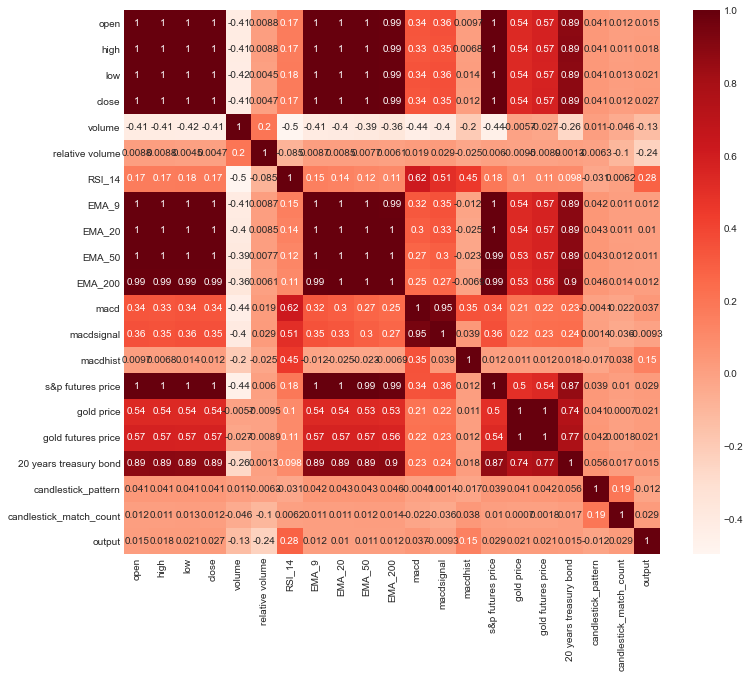

In [47]:
# Visualize the correlation map
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

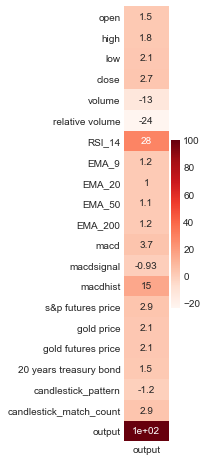

In [48]:
# Visualize the correlation map related to output only
plt.figure(figsize=(1,8))
sns.heatmap(df_scaled.corr()[["output"]]*100, annot=True, cmap=plt.cm.Reds)
plt.show()

In [186]:
# TODO: Drop columns that have near to zero correlation (i.e. less than 0.5)


In [187]:
# TODO: Drop columns that have high correlation


##### Wrapper Methods - Backward Elimination

In [89]:
X = df_scaled.drop(["next close", "output"], axis=1)
y = df_scaled["next close"]

In [90]:
# Initialize the model
model = Ridge()

# Fit the model
model.fit(X=X.to_numpy(), y=y.to_numpy())

# Get the p-values
model.coef_

array([ 5.00806525e-02,  1.67590455e-01,  2.33338061e-01,  3.20655825e-01,
       -2.23002433e-04, -5.27587317e-04,  2.38322212e-03,  7.14271444e-02,
        7.57083794e-02,  3.95722808e-02,  1.12456623e-02,  2.45493599e-03,
        1.16665092e-03,  4.36732237e-03,  2.57602743e-02, -3.19601115e-02,
        3.49787900e-02,  1.09352366e-03])

In [93]:
# Get the columns
cols = list(X.columns)

# Set the maximum p value
pmax = 1

# While length of column is bigger than zero
while(len(cols)>0):
    
    # Initialize a list for p values
    p = []
    
    #
    X_1 = X[cols]
    
    # Initialize the model
    model = Ridge()
    
    # Fit to the model
    model.fit(X=X_1, y=y)
    
    # Get the p-values inside a series
    p = pd.Series(model.coef_, index=cols)
    
    # Get the pmax
    pmax = max(p)
    
    # Get the features with pmax
    feature_with_p_max = p.idxmax()
    
    # If pmax is bigger than 0.05
    if (pmax>0.05):
        
        # Remove the feature from columns
        cols.remove(feature_with_p_max)
        
    # If pmax is less than 0.05
    else:
        
        # Break the loop
        break
        
# Set the selected features
selected_features = cols
print(selected_features)

['volume', 'RSI_14', 'macdhist']


In [94]:
# Backward Elimination - dropping columns which their pvalue is above 0.05
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

NameError: name 'sm' is not defined

##### Wrapper Methods - RFE (Recursive Feature Elimination)

In [95]:
# Rank the columns (1 being the most important one)
model = LinearRegression()
rfe = feature_selection.RFE(model, n_features_to_select=7)
X_rfe = rfe.fit_transform(X_scaled,y)  
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

NameError: name 'feature_selection' is not defined

In [ ]:
pd.DataFrame(rfe.ranking_, index=X.columns, columns=["Rank"])

In [96]:
# Get the optimal number of features
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

NameError: name 'RFE' is not defined

In [ ]:
# Feed the optial number of features as number of features to RFE and get the final set of features
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

##### Embedded Method

In [56]:
X = df_scaled.drop("next close", axis=1).to_numpy()
y = df_scaled["next close"].to_numpy()

In [63]:
n_sample = 1000
X_sample = X[:n_sample]
y_sample = y[:n_sample]

In [64]:
model_tree = GradientBoostingRegressor(n_estimators=100)
model_tree.fit(X_sample, y_sample)
model_tree.feature_importances_ 

array([2.85211588e-02, 3.36041542e-02, 9.15940862e-02, 6.20267104e-01,
       7.48716889e-04, 3.02954344e-04, 1.63878598e-04, 1.39864918e-01,
       1.36264128e-02, 9.59991793e-04, 2.80825231e-04, 5.00139823e-04,
       4.57652878e-04, 3.51275818e-04, 6.61210312e-02, 4.20700827e-04,
       9.07529625e-05, 1.46472343e-03, 6.59522458e-04])

In [65]:
model_ridge = Ridge()
model_ridge.fit(X_sample, y_sample)
model_ridge.coef_

array([ 0.08206152,  0.10354949,  0.10573465,  0.12021447, -0.00174636,
        0.00046484,  0.0029287 ,  0.09963497,  0.10035894,  0.09821065,
        0.07694535,  0.00503514,  0.00417873,  0.00357894,  0.16185937,
       -0.01033606,  0.01274268, -0.00484281,  0.03606733])

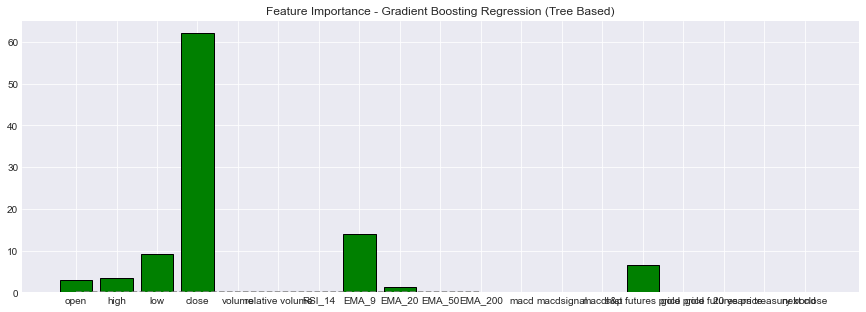

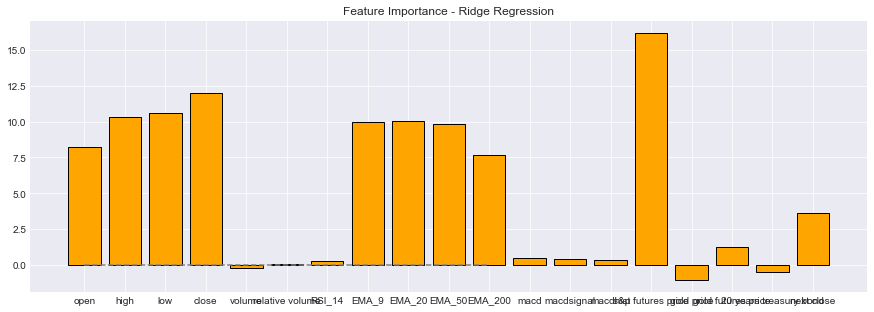

In [66]:
plt.figure(figsize=(15,5))
f1 = pd.DataFrame(model_tree.feature_importances_*100, index=list(df_scaled.drop("output", axis=1).columns.values))
plt.bar(x = list(f1.index),
        height = f1[0].values,
        color="green",
        edgecolor="black")
plt.hlines(0, 0, 10, linestyles="dashed", color="gray")
plt.title("Feature Importance - Gradient Boosting Regression (Tree Based)")
plt.show()

plt.figure(figsize=(15,5))
f2 = pd.DataFrame(model_ridge.coef_*100, index=list(df_scaled.drop("output", axis=1).columns.values))
plt.bar(x = list(f2.index),
        height = f2[0].values,
        color="orange",
        edgecolor="black")
plt.hlines(0, 0, 10, linestyles="dashed", color="gray")
plt.title("Feature Importance - Ridge Regression")
plt.show()

# Models

### Machine Learning

In [92]:
index_to_cut = int(df_scaled.shape[0]*0.90)

x_train = df_scaled.drop("output", axis=1).to_numpy()[:index_to_cut]
y_train = df_scaled["output"].to_numpy()[:index_to_cut]
print("Training set length: ", x_train.shape[0])

x_test = df_scaled.drop("output", axis=1).to_numpy()[index_to_cut:]
y_test = df_scaled["output"].to_numpy()[index_to_cut:]
print("Testing set length: ", x_test.shape[0])

Training set length:  3702
Testing set length:  412


In [93]:
# prepare a list of ml models
def get_models(models=dict()):
    
    # Linear models
    models['linear_regression'] = LinearRegression()
    models['lasso_regressor'] = Lasso()
    models['ridge_regressor'] = Ridge()
    models['elastic_net_regressor'] = ElasticNet()
    models['huber_regressor'] = HuberRegressor()
    models['lasso_lars_regressor'] = LassoLars()
    models['passive_aggressive_regressor'] = PassiveAggressiveRegressor( tol=1e-3)
    models['sgd_regressor'] = SGDRegressor(tol=1e-3)
    
    # Non-linear models
    models['knn_regressor'] = KNeighborsRegressor(n_neighbors=7)
    models['cart_decision_tree_regressor'] = DecisionTreeRegressor()
    models['extra_tree_regressor'] = ExtraTreeRegressor()
    models['support_vector_regressor'] = SVR()
    
    # Ensemble models
    n_trees = 100
    models['ada_boost_regressor'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bagging_regressor'] = BaggingRegressor(n_estimators=n_trees)
    models['random_forest_regressor'] = RandomForestRegressor(n_estimators=n_trees)
    models['extra_tree_regressor_2'] = ExtraTreesRegressor(n_estimators=n_trees)
    models['gradient_boosting_regressor'] = GradientBoostingRegressor(n_estimators=n_trees)
    
    print('Defined %d models' % len(models))
    
    return models

In [94]:
models = get_models()
models

Defined 17 models


{'linear_regression': LinearRegression(),
 'lasso_regressor': Lasso(),
 'ridge_regressor': Ridge(),
 'elastic_net_regressor': ElasticNet(),
 'huber_regressor': HuberRegressor(),
 'lasso_lars_regressor': LassoLars(),
 'passive_aggressive_regressor': PassiveAggressiveRegressor(),
 'sgd_regressor': SGDRegressor(),
 'knn_regressor': KNeighborsRegressor(n_neighbors=7),
 'cart_decision_tree_regressor': DecisionTreeRegressor(),
 'extra_tree_regressor': ExtraTreeRegressor(),
 'support_vector_regressor': SVR(),
 'ada_boost_regressor': AdaBoostRegressor(n_estimators=100),
 'bagging_regressor': BaggingRegressor(n_estimators=100),
 'random_forest_regressor': RandomForestRegressor(),
 'extra_tree_regressor_2': ExtraTreesRegressor(),
 'gradient_boosting_regressor': GradientBoostingRegressor()}

In [95]:
# Loop over the keys of the dictionary
for i_key in models.keys():
    
    # Fit the model to the dataset
    models[i_key].fit(X=x_train, y=y_train)
    
    # Make prediction
    preds = models[i_key].predict(x_test)
    
    # Calculate metrics
    mse = sklearn.metrics.mean_squared_error(np.array(y_test), preds)
    accuracy = sklearn.metrics.accuracy_score(np.array(y_test, "int"), np.array(np.round(preds), "int"))
    
    # Report
    print("====================================================")
    print("Model: ", i_key)
    print("Mean Square Error (MSE): {:.10f}".format(mse))
    print("Accuracy: %{:.2f}".format(accuracy*100))
    print("====================================================")

Model:  linear_regression
Mean Square Error (MSE): 0.0002031306
Accuracy: %100.00
Model:  lasso_regressor
Mean Square Error (MSE): 0.0002964013
Accuracy: %100.00
Model:  ridge_regressor
Mean Square Error (MSE): 0.0003053185
Accuracy: %100.00
Model:  elastic_net_regressor
Mean Square Error (MSE): 0.0002964013
Accuracy: %100.00
Model:  huber_regressor
Mean Square Error (MSE): 0.0001823771
Accuracy: %100.00
Model:  lasso_lars_regressor
Mean Square Error (MSE): 0.0002964013
Accuracy: %100.00
Model:  passive_aggressive_regressor
Mean Square Error (MSE): 0.0007651668
Accuracy: %100.00
Model:  sgd_regressor
Mean Square Error (MSE): 0.0004788220
Accuracy: %100.00
Model:  knn_regressor
Mean Square Error (MSE): 0.0002660693
Accuracy: %100.00
Model:  cart_decision_tree_regressor
Mean Square Error (MSE): 0.0002782122
Accuracy: %100.00
Model:  extra_tree_regressor
Mean Square Error (MSE): 0.0003788770
Accuracy: %100.00
Model:  support_vector_regressor
Mean Square Error (MSE): 0.0006849553
Accuracy:

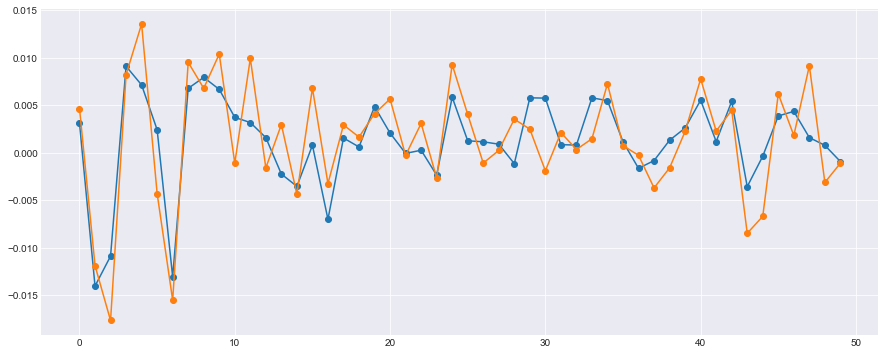

In [111]:
plt.figure(figsize=(15, 6))
plt.plot(preds[:50], "o-")
plt.plot(y_test[:50], "o-")

In [141]:
thumps_up_counter = 0
thumps_down_counter = 0

for i in range(1, len(x_test)):
    
    prediction_ = preds[i]*100
    true_output_ = y_test[i]*100
    
    true_trend = y_test[i]*100 - y_test[i-1]*100
    pred_trend = preds[i]*100 - preds[i-1]*100
    
    print("===================================================")
    print(f"PREDICTION #{i}")
    print("Prediction: {:.2f}%, True Output: {:.2f}%, Difference: {:.2f}".format(prediction_, true_output_, abs(prediction_-true_output_)))

    if ((true_trend>=0) & (pred_trend>=0)) | ((true_trend<0) & (pred_trend<0)):
        print("Correct trend 👍")
        thumps_up_counter+= 1
    else:
        print("Incorrectly trend 👎")
        thumps_down_counter+= 1
    print("===================================================")
    
print(f"Correctly predicted the trend for {thumps_up_counter} times (i.e {round(thumps_up_counter/(thumps_up_counter+thumps_down_counter), 2)*100}%) 👍")
print(f"Incorrect predicted the trend for {thumps_down_counter} times (i.e {round(thumps_down_counter/(thumps_up_counter+thumps_down_counter), 2)*100}%) 👎")

PREDICTION #1
Prediction: -1.40%, True Output: -1.19%, Difference: 0.21
Correct trend 👍
PREDICTION #2
Prediction: -1.09%, True Output: -1.77%, Difference: 0.68
Incorrectly trend 👎
PREDICTION #3
Prediction: 0.91%, True Output: 0.82%, Difference: 0.09
Correct trend 👍
PREDICTION #4
Prediction: 0.71%, True Output: 1.35%, Difference: 0.64
Incorrectly trend 👎
PREDICTION #5
Prediction: 0.24%, True Output: -0.43%, Difference: 0.67
Correct trend 👍
PREDICTION #6
Prediction: -1.31%, True Output: -1.55%, Difference: 0.24
Correct trend 👍
PREDICTION #7
Prediction: 0.68%, True Output: 0.95%, Difference: 0.27
Correct trend 👍
PREDICTION #8
Prediction: 0.79%, True Output: 0.68%, Difference: 0.11
Incorrectly trend 👎
PREDICTION #9
Prediction: 0.67%, True Output: 1.04%, Difference: 0.37
Incorrectly trend 👎
PREDICTION #10
Prediction: 0.37%, True Output: -0.11%, Difference: 0.48
Correct trend 👍
PREDICTION #11
Prediction: 0.32%, True Output: 0.99%, Difference: 0.67
Incorrectly trend 👎
PREDICTION #12
Predictio

### DL

In [43]:
index_to_cut = int(df_scaled.shape[0]*0.90)

x_train = df_scaled.drop("output", axis=1).to_numpy()[:index_to_cut]
y_train = df_scaled["output"].to_numpy()[:index_to_cut]
print("Training set length: ", x_train.shape[0])

x_test = df_scaled.drop("output", axis=1).to_numpy()[index_to_cut:]
y_test = df_scaled["output"].to_numpy()[index_to_cut:]
print("Testing set length: ", x_test.shape[0])

Training set length:  3703
Testing set length:  412


In [60]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(25,1), return_sequences=True))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 25, 32)            4352      
_________________________________________________________________
lstm_16 (LSTM)               (None, 25, 64)            24832     
_________________________________________________________________
lstm_17 (LSTM)               (None, 25, 64)            33024     
_________________________________________________________________
dense_2 (Dense)              (None, 25, 10)            650       
_________________________________________________________________
dense_3 (Dense)              (None, 25, 1)             11        
Total params: 62,869
Trainable params: 62,869
Non-trainable params: 0
_________________________________________________________________
